<a href="https://colab.research.google.com/github/Shopping-Yuan/ML_Project/blob/Shopping_vscode_branch/GBDT/GBDT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'house-prices-advanced-regression-techniques:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F5407%2F868283%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240604%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240604T054634Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8599622bdd97015cbc78839527a7c212506420c60a79503453d966f40c9ed797b2e8efd9bfeab96719bc88a3a54c7877901c12574bb4b6c37461eac432ea274b0456d7fc6757744198b59049fedbf6058f21974d94de9ff3725d02121eb1c046ce2b5ed413150b38639caebdae19fa00d369002658bd7d237918c19b808aa1e7f911a7e2103e8882c153be79c7bedc128ab27ce42f5e534d99c71f76f825119949d5a12414cd6d64584d985da45757582ebc57da1bc3e34b84928364d185056490840d4fb953cbba0e0918aa3b0ecc30bddbbb05d3c5938da309a2bfd25d2b26e543987459a5fb6418bb5db4b889ff832e26b14d08bf1733121ec6c8c764f381'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 203809 bytes downloaded
Downloaded and uncompressed: house-prices-advanced-regression-techniques
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv


In [20]:
from sklearn.model_selection import train_test_split
train_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

In [21]:
train_df.dtypes
train_df.columns.values

array(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'Pav

Drop id and columns with too many missing values.

In [28]:
train_df = train_df.replace([np.inf, -np.inf, ""], np.nan)
null = train_df.isnull().sum()
notnull = train_df.notnull().sum()
train_miss_portion = null[null > 0]/(null[null > 0]+notnull[null > 0])
train_miss_portion

LotFrontage     0.177397
Alley           0.937671
MasVnrType      0.597260
MasVnrArea      0.005479
BsmtQual        0.025342
BsmtCond        0.025342
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtFinType2    0.026027
Electrical      0.000685
FireplaceQu     0.472603
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
PoolQC          0.995205
Fence           0.807534
MiscFeature     0.963014
dtype: float64

In [29]:
test_df = test_df.replace([np.inf, -np.inf, ""], np.nan)
null = test_df.isnull().sum()
notnull = test_df.notnull().sum()
test_miss_portion = null[null > 0]/(null[null > 0]+notnull[null > 0])
test_miss_portion

MSZoning        0.002742
LotFrontage     0.155586
Alley           0.926662
Utilities       0.001371
Exterior1st     0.000685
Exterior2nd     0.000685
MasVnrType      0.612748
MasVnrArea      0.010281
BsmtQual        0.030158
BsmtCond        0.030843
BsmtExposure    0.030158
BsmtFinType1    0.028787
BsmtFinSF1      0.000685
BsmtFinType2    0.028787
BsmtFinSF2      0.000685
BsmtUnfSF       0.000685
TotalBsmtSF     0.000685
BsmtFullBath    0.001371
BsmtHalfBath    0.001371
KitchenQual     0.000685
Functional      0.001371
FireplaceQu     0.500343
GarageType      0.052090
GarageYrBlt     0.053461
GarageFinish    0.053461
GarageCars      0.000685
GarageArea      0.000685
GarageQual      0.053461
GarageCond      0.053461
PoolQC          0.997944
Fence           0.801234
MiscFeature     0.965045
SaleType        0.000685
dtype: float64

In [30]:
drop_features = train_miss_portion[train_miss_portion > 0.5].index.values
drop_features = np.append(drop_features,["Id","MSSubClass"])
drop_features

array(['Alley', 'MasVnrType', 'PoolQC', 'Fence', 'MiscFeature', 'Id',
       'MSSubClass'], dtype=object)

In [31]:
train_data = train_df.drop(axis=0,columns=drop_features,errors='raise')
test_data = test_df.drop(axis=0,columns=drop_features,errors='raise')

In [32]:
train_data.columns.values
train_data.shape

(1460, 74)

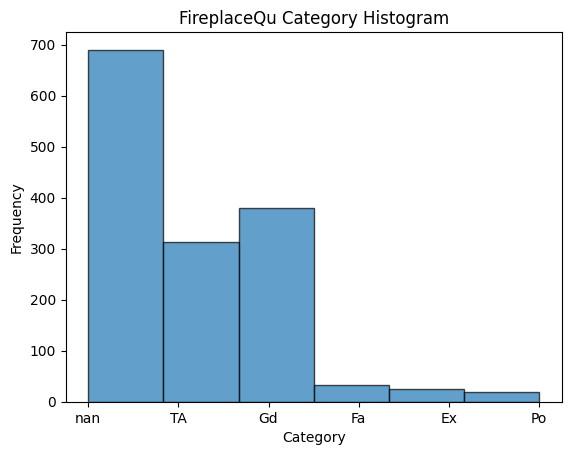

0    0.524675
1    0.000000
2    0.000000
3    1.000000
4    0.000000
Name: FireplaceQu, dtype: float64

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(train_data["FireplaceQu"].to_list(), bins=len(set(train_data["FireplaceQu"])), edgecolor='black', alpha=0.7)
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.title('FireplaceQu Category Histogram')
plt.show()

def freplace_qu_transform(dataset):
  dataset["FireplaceQu"] = dataset["FireplaceQu"].replace(["Ex","Gd","TA","Fa","Po"], [1,1,0,0,0])
  dataset["FireplaceQu"] = dataset["FireplaceQu"].replace(np.nan, dataset["FireplaceQu"].mean())

freplace_qu_transform(train_data)
freplace_qu_transform(test_data)
train_data["FireplaceQu"].head()

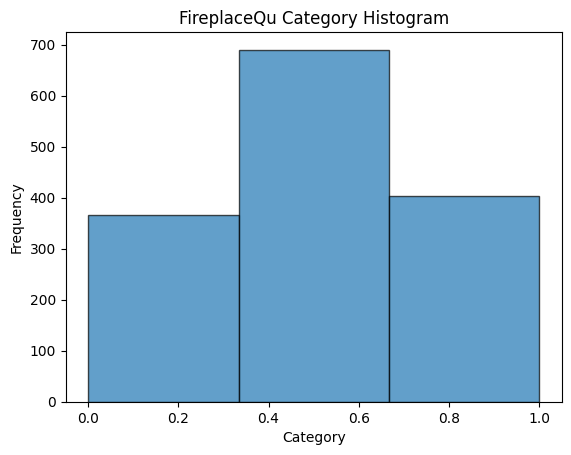

In [34]:
plt.hist(train_data["FireplaceQu"].to_list(), bins=3, edgecolor='black', alpha=0.7)
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.title('FireplaceQu Category Histogram')
plt.show()

In [35]:
from sklearn.preprocessing import LabelEncoder
def labelencoder(dataset,name):
  for n in name :
    label_encoder = LabelEncoder()
    dataset[n] = label_encoder.fit_transform(dataset[n])

In [36]:
fireplaceQu_df = train_data[train_data["FireplaceQu"].isin([1,0]) ][["FireplaceQu","SalePrice"]]
labelencoder(fireplaceQu_df,["FireplaceQu"])
fireplaceQu_df.corr()

,FireplaceQu,SalePrice
FireplaceQu,1.000000,0.200584
SalePrice,0.200584,1.000000


In [37]:
labelencoder(train_data,["LotFrontage"])
train_data[["LotFrontage","SalePrice"]].corr()

,LotFrontage,SalePrice
LotFrontage,1.000000,0.213821
SalePrice,0.213821,1.000000


In [38]:
def condition_1_2_transform(dataset):
  names =  set(dataset["Condition1"].unique().tolist()+dataset["Condition2"].unique().tolist())
  for name in names:
    dataset[name] = ((dataset["Condition1"]==name) + (dataset["Condition2"]==name))>0
    print(name,(dataset[name]>0).sum())
  dataset = dataset.drop(["Condition1","Condition2"],axis = 1)
condition_1_2_transform(train_data)
condition_1_2_transform(test_data)

Artery 48
Feedr 86
RRNe 2
Norm 1445
RRAe 12
RRAn 27
PosN 19
RRNn 7
PosA 9
Artery 47
Feedr 87
RRNe 4
Norm 1444
RRAe 17
RRAn 24
PosN 20
RRNn 4
PosA 12


In [39]:
for dtype in train_data.dtypes.unique():
  print(dtype , train_data.loc[:,lambda n : n.dtypes == dtype].columns.values)

object ['MSZoning' 'Street' 'LotShape' 'LandContour' 'Utilities' 'LotConfig'
 'LandSlope' 'Neighborhood' 'Condition1' 'Condition2' 'BldgType'
 'HouseStyle' 'RoofStyle' 'RoofMatl' 'Exterior1st' 'Exterior2nd'
 'ExterQual' 'ExterCond' 'Foundation' 'BsmtQual' 'BsmtCond' 'BsmtExposure'
 'BsmtFinType1' 'BsmtFinType2' 'Heating' 'HeatingQC' 'CentralAir'
 'Electrical' 'KitchenQual' 'Functional' 'GarageType' 'GarageFinish'
 'GarageQual' 'GarageCond' 'PavedDrive' 'SaleType' 'SaleCondition']
int64 ['LotFrontage' 'LotArea' 'OverallQual' 'OverallCond' 'YearBuilt'
 'YearRemodAdd' 'BsmtFinSF1' 'BsmtFinSF2' 'BsmtUnfSF' 'TotalBsmtSF'
 '1stFlrSF' '2ndFlrSF' 'LowQualFinSF' 'GrLivArea' 'BsmtFullBath'
 'BsmtHalfBath' 'FullBath' 'HalfBath' 'BedroomAbvGr' 'KitchenAbvGr'
 'TotRmsAbvGrd' 'Fireplaces' 'GarageCars' 'GarageArea' 'WoodDeckSF'
 'OpenPorchSF' 'EnclosedPorch' '3SsnPorch' 'ScreenPorch' 'PoolArea'
 'MiscVal' 'MoSold' 'YrSold' 'SalePrice']
float64 ['MasVnrArea' 'FireplaceQu' 'GarageYrBlt']
bool ['Artery'

In [40]:
def get_dummy(dataset):
    names = list(dataset.dtypes[dataset.dtypes == object].index)
    dataset_encoder = pd.DataFrame()
    for name in dataset.columns:
        if name in names:
            dataset_encoder = pd.concat([dataset_encoder,pd.get_dummies(dataset[name],prefix = name)],axis = 1)
        else :
            dataset_encoder[name] = dataset[name]
    return dataset_encoder

In [42]:
train_encoder = get_dummy(train_data)
test_encoder = get_dummy(test_data)
display(train_encoder.head(5))
print(len(train_encoder.columns))
print(train_encoder.shape)

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotFrontage,LotArea,Street_Grvl,Street_Pave,LotShape_IR1,...,SalePrice,Artery,Feedr,RRNe,Norm,RRAe,RRAn,PosN,RRNn,PosA
0,False,False,False,True,False,36,8450,False,True,False,...,208500,False,False,False,True,False,False,False,False,False
1,False,False,False,True,False,51,9600,False,True,False,...,181500,False,True,False,True,False,False,False,False,False
2,False,False,False,True,False,39,11250,False,True,True,...,223500,False,False,False,True,False,False,False,False,False
3,False,False,False,True,False,31,9550,False,True,True,...,140000,False,False,False,True,False,False,False,False,False
4,False,False,False,True,False,55,14260,False,True,True,...,250000,False,False,False,True,False,False,False,False,False


276
(1460, 276)


In [54]:
from sklearn.impute import KNNImputer
def imputed(dataset):
  imputer = KNNImputer(n_neighbors=10)
  imputed_data = imputer.fit_transform(dataset)
  df_imputed = pd.DataFrame(imputed_data)
  df_imputed.columns = dataset.columns
  return df_imputed
train_imputed = imputed(train_encoder)
test_imputed = imputed(test_encoder)

In [55]:
import seaborn as sns
# sns.heatmap(train_encoder.corr())
r_series = train_imputed.corr()["SalePrice"].abs()
r_series.sort_values(ascending = False)
good_features = r_series[r_series>0.2].index
print(good_features)

train_imputed = train_imputed.loc[:,good_features]
test_data = test_imputed.loc[:,good_features.drop("SalePrice")]
train_imputed.head()

Index(['MSZoning_RL', 'MSZoning_RM', 'LotFrontage', 'LotArea', 'LotShape_IR1',
       'LotShape_Reg', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_StoneBr', 'HouseStyle_2Story', 'OverallQual', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle_Gable', 'RoofStyle_Hip',
       'Exterior1st_VinylSd', 'Exterior2nd_VinylSd', 'MasVnrArea',
       'ExterQual_Ex', 'ExterQual_Gd', 'ExterQual_TA', 'Foundation_BrkTil',
       'Foundation_CBlock', 'Foundation_PConc', 'BsmtQual_Ex', 'BsmtQual_Gd',
       'BsmtQual_TA', 'BsmtExposure_Gd', 'BsmtExposure_No', 'BsmtFinType1_GLQ',
       'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC_Ex',
       'HeatingQC_TA', 'CentralAir_N', 'CentralAir_Y', 'Electrical_SBrkr',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath',
       'HalfBath', 'KitchenQual_Ex', 'KitchenQual_Gd', 'KitchenQual_TA',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageType_Attchd', 'GarageType_BuiltIn',
       'GarageType_Detchd', 'GarageYrBlt', 'G

,MSZoning_RL,MSZoning_RM,LotFrontage,LotArea,LotShape_IR1,LotShape_Reg,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_StoneBr,HouseStyle_2Story,...,GarageQual_TA,GarageCond_TA,PavedDrive_N,PavedDrive_Y,WoodDeckSF,OpenPorchSF,SaleType_New,SaleType_WD,SaleCondition_Partial,SalePrice
0,1.0,0.0,36.0,8450.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,1.0,0.0,61.0,0.0,1.0,0.0,208500.0
1,1.0,0.0,51.0,9600.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,298.0,0.0,0.0,1.0,0.0,181500.0
2,1.0,0.0,39.0,11250.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,1.0,0.0,42.0,0.0,1.0,0.0,223500.0
3,1.0,0.0,31.0,9550.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,1.0,0.0,35.0,0.0,1.0,0.0,140000.0
4,1.0,0.0,55.0,14260.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,1.0,0.0,1.0,192.0,84.0,0.0,1.0,0.0,250000.0


In [47]:
train_data, val_data, train_label, val_label, = \
train_test_split(train_imputed.drop(["SalePrice"],axis = 1),train_encoder["SalePrice"], test_size=0.2, random_state=1)
train_data.shape,train_label.shape

((1168, 66), (1168,))

In [48]:
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
params = {
    "n_estimators": 600,
    "max_depth": 4,
    "min_samples_split": 2,
    "learning_rate": 0.01,
    "loss": "squared_error",
    "random_state" : 1,
}
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(train_data, train_label)

GradientBoostingRegressor(learning_rate=0.01, max_depth=4, n_estimators=600,
                          random_state=1)

In [62]:
import math
train_score = np.zeros((params["n_estimators"],), dtype=np.float64)
val_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, train_pred in enumerate(reg.staged_predict(train_data)):
    train_score[i] = \
    mean_squared_error(map(math.log,train_label.tolist()), map(math.log,train_pred.tolist()))

for i, val_pred in enumerate(reg.staged_predict(val_data)):
    val_score[i] = \
    mean_squared_error(map(math.log,val_label.tolist()), map(math.log,val_pred.tolist()))

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, val_score, "r-", label="Valid Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

TypeError: Expected sequence or array-like, got <class 'map'>

In [59]:
out_df = pd.DataFrame(reg.predict(test_data),index = test_data.index)
out_df.to_csv("sample_submission.csv")
out_df.head()

,0
0,120247.632117
1,152827.914392
2,181154.667917
3,190914.909439
4,193161.690699
